<a href="https://colab.research.google.com/github/SofyaKirsanova/Log_Analysis/blob/main/Log_Preprossecing_with_text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Датасет [BGL](https://github.com/logpai/loghub/tree/master/BGL)**

По ссылке представлена часть датасета (в нем 2000 строк). На нем и будет тестироваться алгоритм. Полный датасет содержит 4 747 963 строки (из них 348 460 аномалий).

Из описания датасета: 

Это открытый набор данных логов, собранных из суперкомпьютерной системы BlueGene/L в Национальной лаборатории Лоуренса Ливермора (LLNL) в Ливерморе, Калифорния, с 131 072 процессорами и 32 768 ГБ памяти. 

Лог содержит предупреждающие и не предупреждающие сообщения, которые идентифицированы тегами категорий предупреждений. В первом столбце "-" указывает на сообщения, не содержащие предупреждений, в то время как другие являются предупреждающими сообщениями. Эта информация поддается обнаружению предупреждений и прогнозированию. Она использовалась в нескольких исследованиях по анализу логов, обнаружению аномалий и прогнозированию сбоев.

Более подробная информация есть в оригинальной статье:

Adam J. Oliner, Jon Stearley. What Supercomputers Say: A Study of Five System Logs, in Proc. of IEEE/IFIP International Conference on Dependable Systems and Networks (DSN), 2007.

Вид логов в наборе:

```
- 1117842974 2005.06.03 R24-M0-N1-C:J13-U11 2005-06-03-16.56.14.254137 R24-M0-N1-C:J13-U11 RAS KERNEL INFO 162 double-hummer alignment exceptions
- 1117843015 2005.06.03 R21-M1-N6-C:J08-U11 2005-06-03-16.56.55.309974 R21-M1-N6-C:J08-U11 RAS KERNEL INFO 141 double-hummer alignment exceptions
- 1117848119 2005.06.03 R16-M1-N2-C:J17-U01 2005-06-03-18.21.59.871925 R16-M1-N2-C:J17-U01 RAS KERNEL INFO CE sym 2, at 0x0b85eee0, mask 0x05
APPREAD 1117869872 2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.24.32.432192 R04-M1-N4-I:J18-U11 RAS APP FATAL ciod: failed to read message prefix on control stream (CioStream socket to 172.16.96.116:33569
APPREAD 1117869876 2005.06.04 R27-M1-N4-I:J18-U01 2005-06-04-00.24.36.222560 R27-M1-N4-I:J18-U01 RAS APP FATAL ciod: failed to read message prefix on control stream (CioStream socket to 172.16.96.116:33370
- 1117942120 2005.06.04 R30-M0-N7-C:J08-U01 2005-06-04-20.28.40.767551 R30-M0-N7-C:J08-U01 RAS KERNEL INFO CE sym 20, at 0x1438f9e0, mask 0x40
- 1117955341 2005.06.05 R25-M0-N7-C:J02-U01 2005-06-05-00.09.01.903373 R25-M0-N7-C:J02-U01 RAS KERNEL INFO generating core.2275
- 1117955392 2005.06.05 R24-M1-N8-C:J09-U11 2005-06-05-00.09.52.516674 R24-M1-N8-C:J09-U11 RAS KERNEL INFO generating core.862
```
Первые 3 и последние 3 строки не имеют ошибок, а в 4, 5 и 6 строках есть данные об ошибках

**Алгоритм предварительной обработки: Template2Vec**

Он основан на известном алгоритме Word2Vec, который создает векторы, являющиеся представлениями каких-то функций слов  (например, контекст отдельных слов).

Однако он не улавливает семантическую информацию: синонимы и антонимы. Слова, имеющие похожий или одинаковый контекст в двух шаблонах логов, во многих случаях могут быть антонимами, что делает два шаблона очень
разными. Например, слово “вниз” в шаблоне T1
и слово “вверх” в шаблоне T3 на рисунке, которые являются
антонимами, имеют один и тот же контекст. 

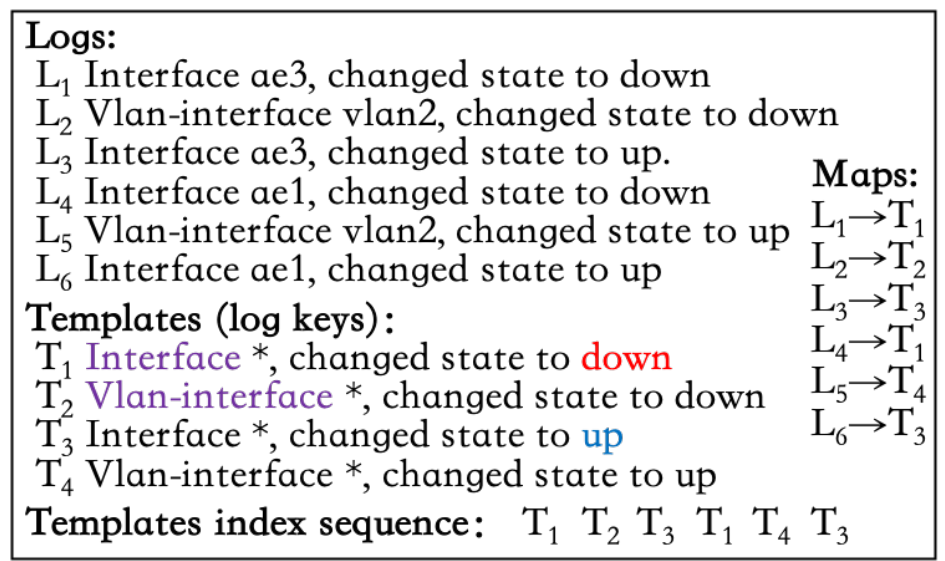



Очевидно, что эти два шаблона имеют противоположное значение, и у них должны быть очень разные векторы. Поэтому необходимо фиксировать
семантическую информацию при построении векторов для представления шаблонов.
В статьяе предлагается новый метод представления слов -- template2Vec, который основан на синонимах и антонимах для эффективного представления слов в распределенных шаблонах.
Template2Vec включает в себя три этапа на этапе
автономного обучения: 

(1) Создание набора синонимов и антонимов. Как показано в таблице 1, универсальные синонимы и антонимы можно найти в лексической базой данных для английского языка [WordNet](https://wordnet.princeton.edu/). Однако некоторые доменные синонимы
и антонимы должны быть добавлены вручную на основе знаний о домене. Поэтому мы сначала ищем синонимы и антонимы слов в шаблонах в WordNet. После этого можно вручную обновлять синонимы и антонимы.
 
("Operators" в таблице означает ввод вручную)
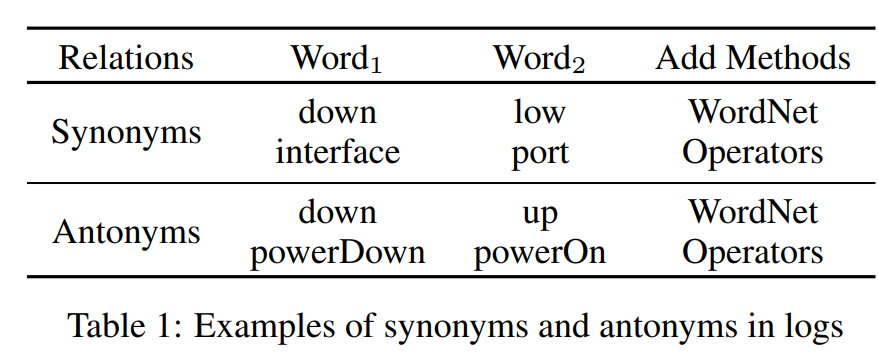

(2) Создание векторов слов. Для этого применяется [dLCE](https://ieeexplore.ieee.org/document/6904105) [Nguyen et al., 2016], которая представляет собой распределенную лексико-контрастную модель встраивания, которая и представляет слова в шаблонах.

(3) Вычисление векторов шаблонов. Для шаблона мы вычисляем его вектор, который является средневзвешенным значением векторов слов слов в шаблоне, чтобы представить распределение шаблона. На этапе обнаружения в реальном времени он сопоставит “временный” вектор шаблона с существующим для новых типов логов. Таким образом, template2Vec объединяет знания о предметной области операторов и модель dLCE для точной генерации векторов шаблонов.

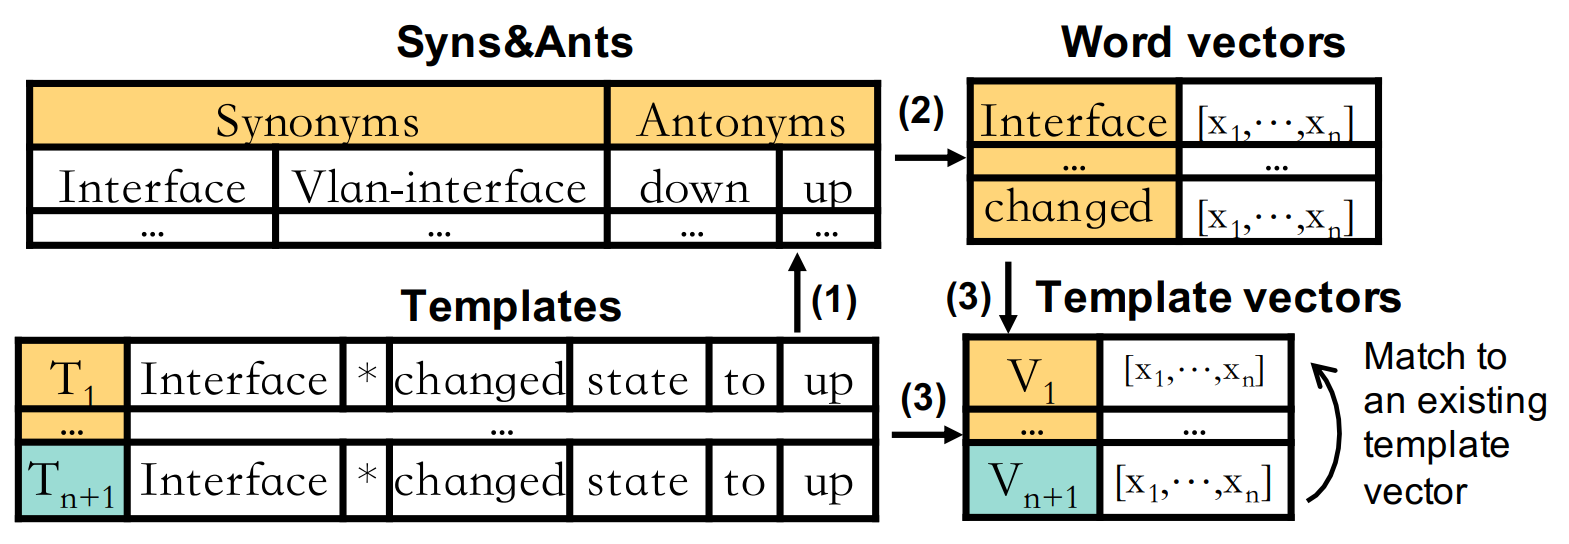

Сначала применим Word2Vec к датасету BGL. 

[Реализация Word2Vec](https://github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

Немного подробнее про Word2Vec. 

**Википедия:**

  Word2vec — общее название для совокупности моделей на основе искусственных нейронных сетей, предназначенных для получения векторных представлений слов на естественном языке. 

***Описание***

  Работа программы осуществляется следующим образом: word2vec принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор, выдавая координаты слов на выходе. Сначала он генерирует словарь корпуса, а затем вычисляет векторное представление слов, «обучаясь» на входных текстах. Векторное представление основывается на контекстной близости: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, имеющие схожий смысл), будут иметь близкие (по косинусному расстоянию) векторы. Полученные векторные представления слов могут быть использованы для обработки естественного языка и машинного обучения.

***Алгоритмы обучения***

  В word2vec реализованы два основных алгоритма обучения: CBoW (англ. Continuous Bag of Words, «непрерывный мешок со словами», англ. bag — мультимножество) и Skip-gram. CBoW — архитектура, которая предсказывает текущее слово, исходя из окружающего его контекста. Архитектура типа Skip-gram действует наоборот: она использует текущее слово, чтобы предугадывать окружающие его слова. Построение модели word2vec возможно с помощью двух данных алгоритмов. Порядок слов контекста не оказывает влияния на результат ни в одном из этих алгоритмов.

***Результаты***

  Получаемые на выходе векторные представления слов позволяют вычислять «семантическое расстояние» между словами. Так, можно находить похожие по значению слова. Обычно приводят пример с королём и королевой: король относится к мужчине также, как королева к женщине. Word2vec выполняет прогнозирование на основании контекстной близости этих слов. Так как инструмент word2vec основан на обучении простой нейронной сети, чтобы добиться его наиболее эффективной работы, необходимо использовать большие корпусы для его обучения. Это позволяет повысить качество предсказаний.

**Работа алгоритма Word2Vec на датасетах BGL и HDFS из статьи**


In [15]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pylab
from sklearn.manifold import TSNE
import operator # сортировка элементов в словаре по значению
from math import ceil

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
def preprocess_text(text): # чистка текста от служебных символов
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    return text

def read_data(filename):
  filename = '/BGL_2k.txt'
  with open(filename,'r') as f:
    data = []
    file_string = f.read()
    file_string = preprocess_text(file_string)
    file_string = file_string.split(' ')
    data.extend(file_string)
  return data
  
words = read_data('BGL_2k.txt')
print('Data size: %d' % len(words))
print('Example words (start): ', words[:10])
print('Example words (end): ', words[-10:])

Data size: 67935
Example words (start):  ['', '1117838570', '2005', '06', '03', 'r02', 'm1', 'n0', 'c', 'j12']
Example words (end):  ['kernel', 'info', 'ciod', 'generated', '128', 'core', 'files', 'for', 'program', '/g/g24/germann2/spasm_mini/meam/r13']


In [10]:
vocabulary_size = 0
def build_dataset(words):
  global vocabulary_size
  count = [['UNK', -1]]

  # сортировка слов по частоте
  count.extend(collections.Counter(words).most_common())
  dictionary = dict()

  # создание уникального номера для каждого слова
  for word, c in count:
    if c < 10:
        continue
    dictionary[word] = len(dictionary)
    vocabulary_size += 1
    
  data = list()
  unk_count = 0
  
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  
      unk_count = unk_count + 1
    data.append(index)
    
  count[0][1] = unk_count
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK):', count[:5])
print('Sample data:', data[:10])
print('Vocabulary size: ', vocabulary_size)

Most common words (+UNK): [['UNK', 6783], ('2005', 4003), ('c', 3489), ('', 2342), ('m0', 2030)]
Sample data: [2, 0, 0, 11, 23, 107, 6, 29, 1, 42]
Vocabulary size:  354


Суть работы алгоритма:

1. Устанавливаем окно (например, из трёх слов), которое скользит по всему тексту.

2. Скользящее окно генерирует образцы для обучения нашей модели

Когда это окно скользит по тексту, мы (фактически) генерируем набор данных, который затем используем для обучения модели. 

Когда мы начинаем, окно располагается на первых трёх словах предложения:

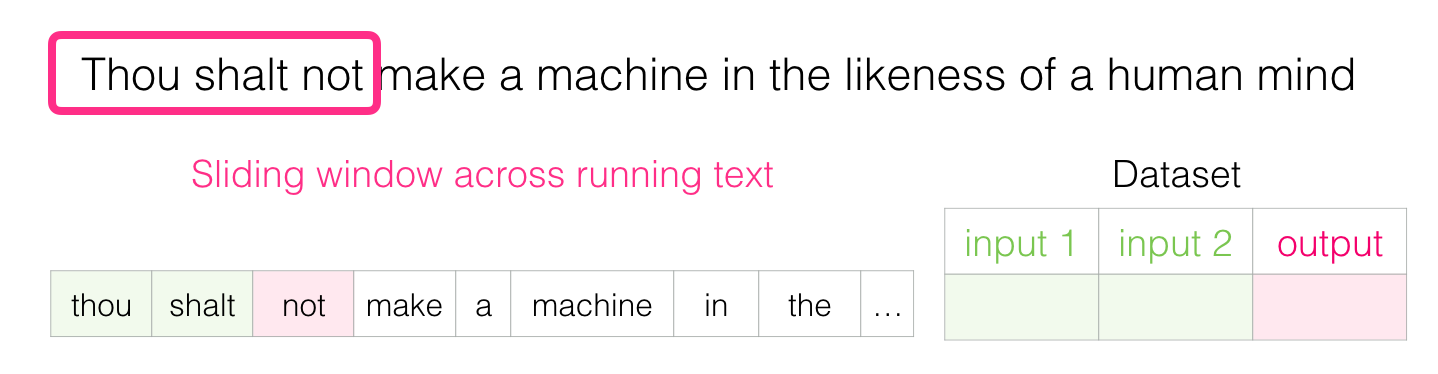

Первые два слова принимаем за признаки, а третье слово — за метку:

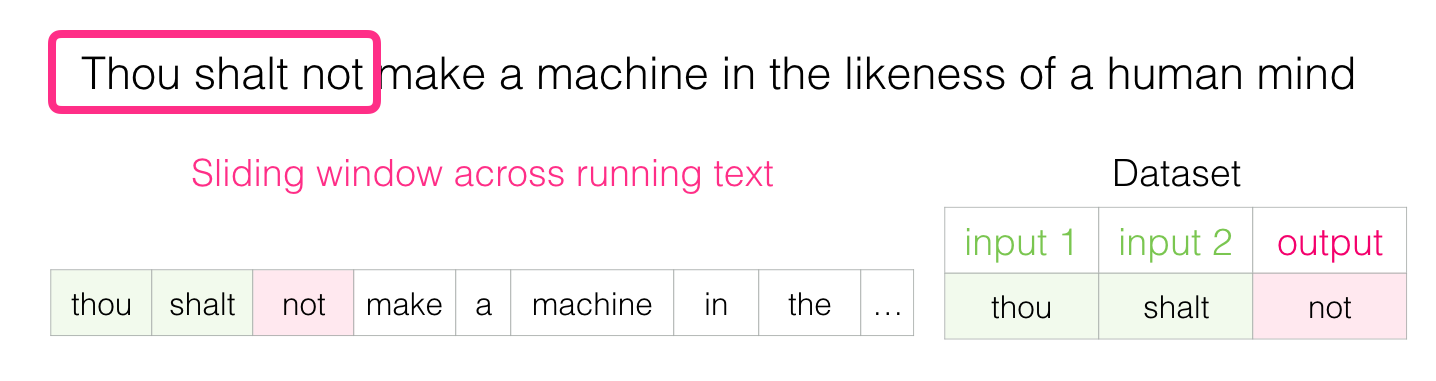

Затем перемещаем окно в следующую позицию и создаём второй образец:

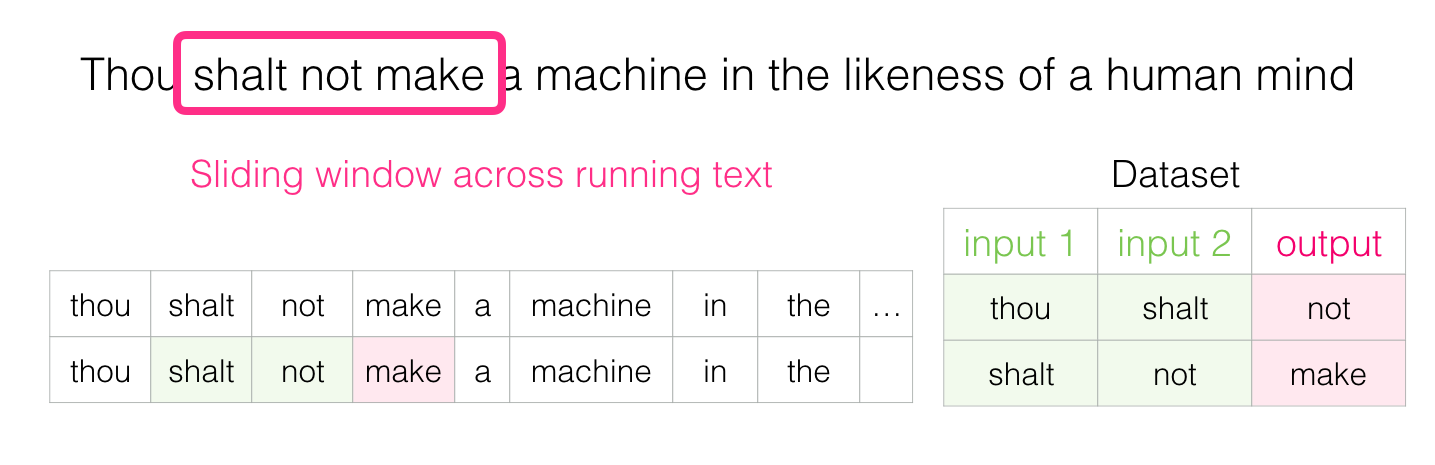

Скоро у нас накапливается больший набор данных:

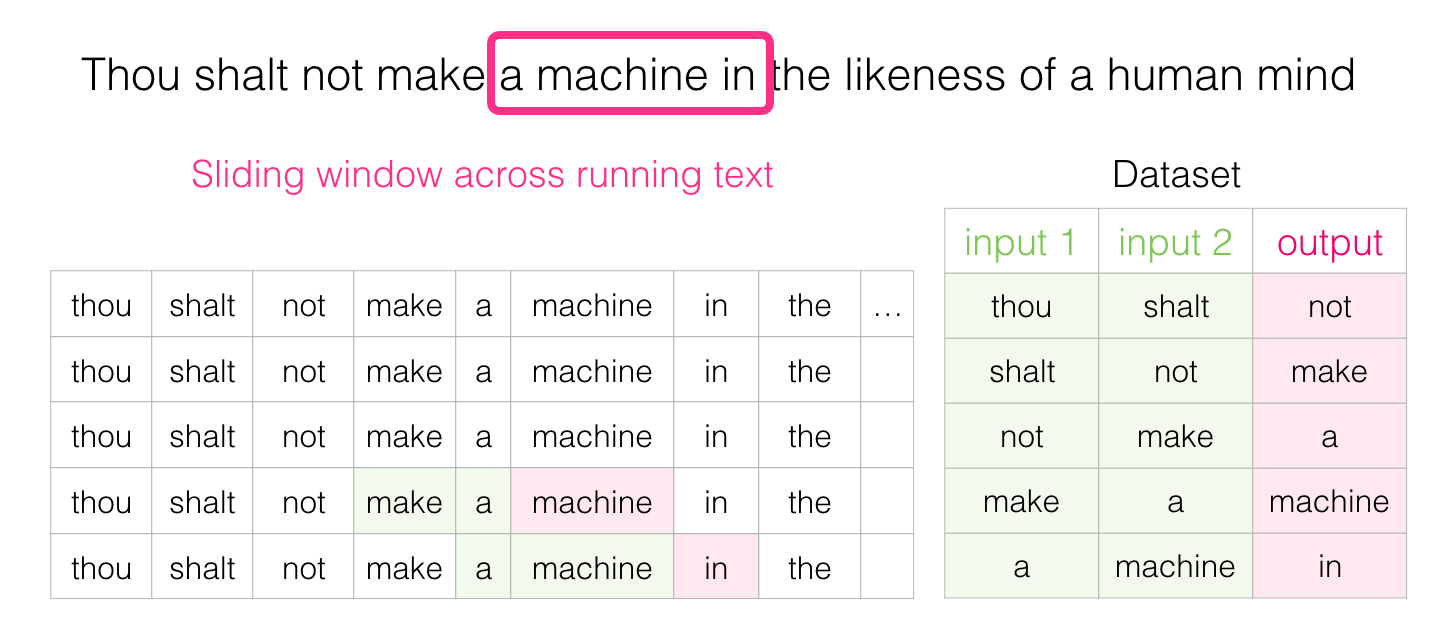

In [11]:
data_index = 0

def generate_batch(batch_size, window_size):
  global data_index 

  batch = np.ndarray(shape = (batch_size), dtype = np.int32) # массив для хранения текущего слова
  labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32) # массив для слова, следующего за текущем
  span = 2 * window_size + 1 # определяет размер "окна"
  queue = collections.deque(maxlen = span) # буфер содержит данные, содержащиеся в пределах диапазона
  
  for _ in range(span): # заполняем буффер и меняем индекс слова
    queue.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size // (2 * window_size)):
    k = 0
    # нужно не учитывать целевое слово
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * (2*window_size) + k] = queue[window_size]
      labels[i * (2*window_size) + k, 0] = queue[j]
      k += 1 

    queue.append(data[data_index]) # каждый раз, когда мы читаем слово, нужно обновить очередь

    data_index = (data_index + np.random.randint(window_size)) % len(data) # если дошли до конца, начинаем заново
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch, labels = generate_batch(batch_size=8, window_size=2)
print('\nwith window_size = %d:' %2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['', '2005', '2005', '06', '03', 'r02', 'm1', 'n0']

with window_size = 2:
    batch: ['2005', '2005', '2005', '2005', '06', '06', '06', '06']
    labels: ['', '2005', '06', '03', '2005', '2005', '03', 'r02']


In [16]:
batch_size = 128 
embedding_size = 64 
window_size = 4 

num_sampled = 32 # Number of negative examples to sample.

tf.compat.v1.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

################################################
#            Model variables                   #
################################################

# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Neural network weights and biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.1 / math.sqrt(embedding_size))
)
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],-0.01,0.01))

# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)
#embed = tf.nn.dropout(embed, keep_prob=0.8)
################################################
#            Computes loss                     #
################################################
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

################################################
#            Optimization                      #
################################################
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

################################################
#            For evaluation                    #
################################################
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

In [17]:
num_steps = 250001

session = tf.InteractiveSession()

# Initialize the variables in the graph
tf.global_variables_initializer().run()
print('Initialized')
average_loss = 0

for step in range(num_steps):

    # Generate a single batch of data
    batch_data, batch_labels = generate_batch(
      batch_size, window_size)

    # Optimize the embedding layer and neural network
    # compute loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    # Update the average loss variable
    average_loss += l

    if (step+1) % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 5000

      print('Average loss at step %d: %f' % (step + 1, average_loss))
      average_loss = 0

sg_embeddings = normalized_embeddings.eval()
session.close()

Initialized
Average loss at step 5000: 3.141250
Average loss at step 10000: 2.844438
Average loss at step 15000: 2.795503
Average loss at step 20000: 2.775168
Average loss at step 25000: 2.757774
Average loss at step 30000: 2.777934
Average loss at step 35000: 2.750806
Average loss at step 40000: 2.777320
Average loss at step 45000: 2.760180
Average loss at step 50000: 2.744336
Average loss at step 55000: 2.757691
Average loss at step 60000: 2.741002
Average loss at step 65000: 2.761078
Average loss at step 70000: 2.716775
Average loss at step 75000: 2.766323
Average loss at step 80000: 2.755330
Average loss at step 85000: 2.742769
Average loss at step 90000: 2.753420
Average loss at step 95000: 2.735352
Average loss at step 100000: 2.758262
Average loss at step 105000: 2.718887
Average loss at step 110000: 2.760192
Average loss at step 115000: 2.753442
Average loss at step 120000: 2.731382
Average loss at step 125000: 2.748976
Average loss at step 130000: 2.726402
Average loss at step

In [18]:
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(sg_embeddings)

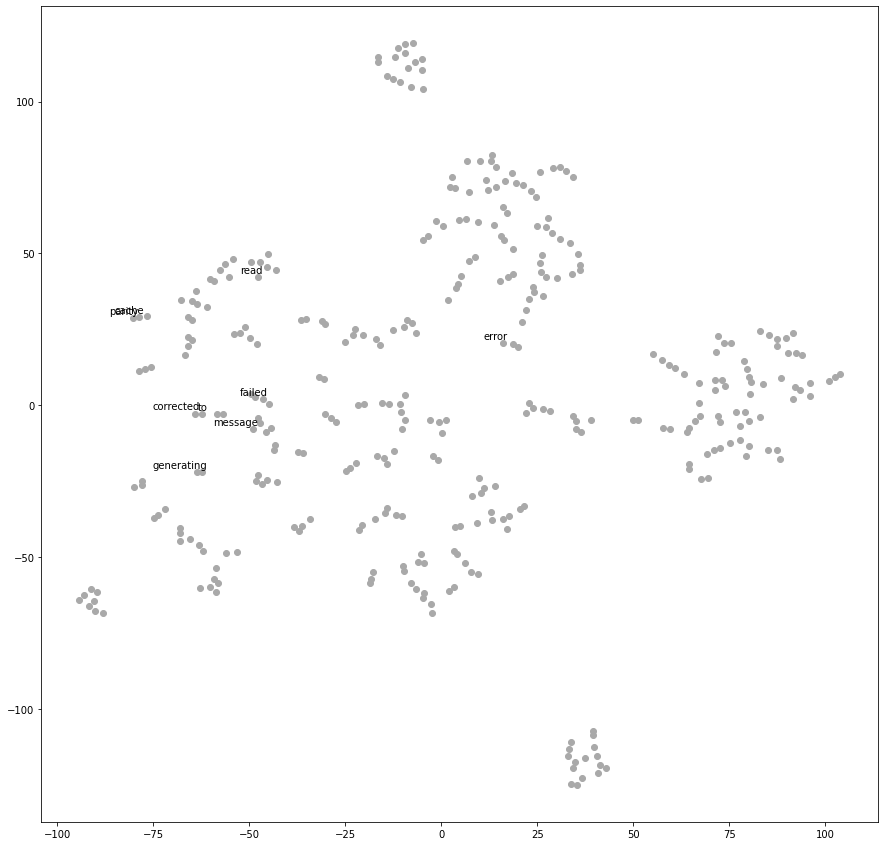

In [19]:
selected_words = ['KERNEL','INFO','RAS','generating','cache','parity','error','corrected','failed','to','read','message', 'FATAL']

words = [reverse_dictionary[i] for i in np.arange(vocabulary_size)]

pylab.figure(figsize = (15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c = 'darkgray')   
    if label in selected_words:
        pylab.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points',
                       ha = 'right', va = 'bottom', fontsize=10)
        
pylab.show()
